### Import & init

In [5]:
import numpy as np
import PIL.Image as Image

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd

import torch
from torch_snippets import *
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import selectivesearch
import xml.etree.ElementTree as ET
import json

os.chdir('/Users/andreastheilgaard/Desktop/deep-learning-in-computer-vison/')
#os.chdir('/zhome/0a/0/137912/mihai/deep-learning-in-computer-vison')
datapath = "data/Potholes/"

with open(f"{datapath}splits.json") as json_data:
    data = json.load(json_data)


from omegaconf import OmegaConf

config = OmegaConf.create({
    'size': 512, # org size mean 575 x 766
    'batch_size': 4, #6
    'seed': 42,
    'workers': 0, #3
})

In [3]:
def read_content(name: str):

    tree = ET.parse(f"{datapath}annotated-images/{name}.xml")
    root = tree.getroot()
    
    img = Image.open(f"{datapath}annotated-images/{name}.jpg")
    list_with_all_boxes = []

    for boxes in root.iter('object'):
        # filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_boxes, img

class Potholes(torch.utils.data.Dataset):
    def __init__(self,split,transform=None,config=None):
        self.transform = transform
        self.split = split
        self.box_transformer = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.split)

    def __getitem__(self, idx):
        boxes, img = read_content(name=self.split[idx])
        #img = img/255
        original_height, original_width, _ = np.array(img).shape
        img_resized = self.transform(img)
        x_scale = config.size / original_width
        y_scale = config.size / original_height
        scaled_bboxes = [[x1 * x_scale, y1 * y_scale, x2 * x_scale, y2 * y_scale] for x1, y1, x2, y2 in boxes]
        if len(scaled_bboxes) != 19:
            iters = 19-len(scaled_bboxes)
            for _ in range(iters):
                scaled_bboxes.append([-1,-1,-1,-1])
                
        boxes= self.box_transformer(np.array(scaled_bboxes))
        return img_resized, boxes
        #return img,boxes
    
def get_data(traindata,testdata):
    size = config.size
    transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()])
    trainset = Potholes(split=traindata,transform=transform,config=config)
    testset = Potholes(split=testdata,transform=transform,config=config)
    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
    test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))

    return train_loader,test_loader

def get_sizes(train_loader):
    img_width_list = []
    img_height_list = []
    for batch in train_loader:
        img,_ = batch
        img_width_list.append(img.shape[2])
        img_height_list.append(img.shape[3])
    return np.mean(img_width_list), np.mean(img_height_list)

def extract_box(box):
    # img bs,3,H,W  , box, bs,1,19,4
    #img,box = batch
     # img bs,3,H,W  , box [#object_box,4]
    return [box[x][box[x]!=-1].reshape(-1,4).numpy() for x in range(config.batch_size)]

def plot_img_and_box(img,box_list,gt=None,linewidth=3):
    if torch.is_tensor(box_list):
        box_list = extract_box(box_list)
    if torch.is_tensor(img[0]):
        img = [i.permute(1,2,0) for i in img]
    n = len(box_list)
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(8.5, 5),dpi=100)
    if n==1: 
        ax = [ax]
    for i,boxes in enumerate(box_list):
        ax[i].imshow(img[i])
        ax[i].set_axis_off()
        if gt is not None:
            if torch.is_tensor(gt): gt = [g[0] for g in gt]
            for x1,y1,x2,y2 in gt[i]:
                ax[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=linewidth+1, edgecolor=(0,1,0), facecolor='none'))
        for x1,y1,x2,y2 in boxes:
            ax[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=linewidth, edgecolor=(1,0,0), facecolor='none'))

def extract_candidates(images):
    min_candidate_scale = 0.05
    max_candidate_scale = 1
    batch_candidates = []
    for i in range(config.batch_size):
        img = images[i]
        if img.shape[0] == 3:
            img = img.permute(1,2,0)
        img_lbl, regions = selectivesearch.selective_search(img, scale=1,sigma=0.8, min_size=100)

        img_area = np.prod(img.shape[:2])
        candidates = []
        for r in regions:
            if r['rect'] in candidates: continue
            if r['size'] < (min_candidate_scale*img_area): continue
            if r['size'] > (max_candidate_scale*img_area): continue
            x1, y1, w, h = r['rect']
            x2 = w+x1
            y2 = h+y1
            candidates.append([x1,y1,x2,y2])
        batch_candidates.append(candidates)
    return batch_candidates  

### Datasplit

In [4]:
traindata = [(x.split('.'))[0] for x in data['train']]
testdata = [(x.split('.'))[0] for x in data['test']]
train_loader,test_loader = get_data(traindata=traindata,testdata=testdata)
images,boxes = next(iter(train_loader))

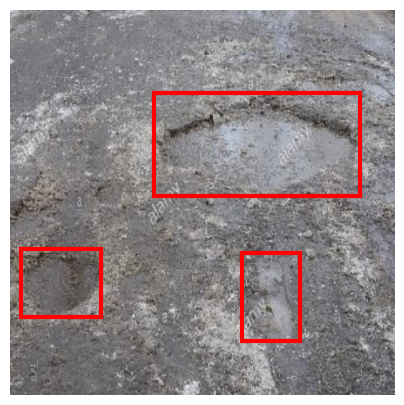

In [125]:
plot_img_and_box([images[0].permute(1,2,0).numpy()],[extract_box(boxes)[0]])

### Selective Search

In [127]:
images,boxes = next(iter(train_loader))
candidates = extract_candidates(images)

ground_t = extract_box(boxes)

/zhome/0a/0/137912/myenv/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


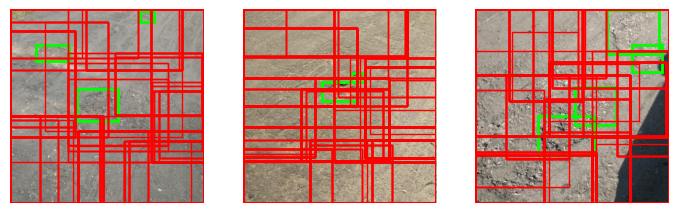

In [128]:
plot_img_and_box(images[:3],candidates[:3],gt=boxes[:3],linewidth=1)

In [129]:
def get_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [134]:
def box_compare(ground_t, candidates, thres=0.3):
    batch_iou, batch_roi, batch_clss, batch_deltas = [], [], [], []
    batch_best_iou = []
    W, H = config.size, config.size

    for i in range(len(candidates)):
        ious, rois, clss, deltas = [], [], [], []
        best_iou = []
        candidate_boxes = candidates[i]
        ground_truth_boxes = ground_t[i]

        # ious = np.array([[get_iou(candidate, gt_box) for candidate in candidate_boxes] for gt_box in ground_truth_boxes]).T

        for gt_box in ground_truth_boxes:
            
            candidate_ious = np.array([get_iou(candidate, gt_box) for candidate in candidate_boxes])
            ious.append(candidate_ious)

            # Find the index of a candidate (best_iou_at) 
            # that has the highest IoU and the corresponding ground truth (best_bb)
            idx = np.argmax(candidate_ious)

            best_iou.append(candidate_ious[idx])
            best_bb = candidate_boxes[idx]

            if candidate_ious[idx] > thres:
                clss.append('pothole')
                _x, _y, _X, _Y = best_bb
                cx, cy, cX, cY = gt_box
                delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
                deltas.append(delta)
            else: 
                clss.append('background')

            rois.append(np.array(gt_box) / np.array([W, H, W, H]))

        batch_iou.append(ious)
        batch_best_iou.append(best_iou)
        batch_roi.append(rois)
        batch_clss.append(clss)
        batch_deltas.append(deltas)

    return batch_iou, batch_best_iou, batch_roi, batch_clss, batch_deltas

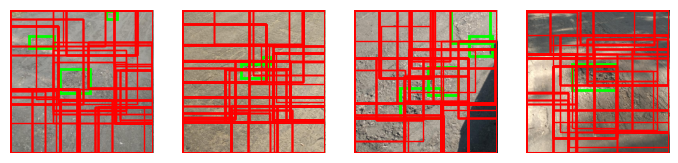

In [140]:
plot_img_and_box(images,candidates,gt=boxes,linewidth=1)

In [141]:
batch_iou, batch_best_iou, batch_roi, batch_clss, batch_deltas = box_compare(ground_t,candidates)
batch_best_iou

[[0.20235384900226908, 0.1240056350103529, 0.027167346931845044],
 [0.09366339372829514, 0.014193075725053624],
 [0.34638924332746374,
  0.26394229909465755,
  0.21720465368198197,
  0.12443963162221382],
 [0.3839965762275223]]

In [142]:
batch_best_iou

[[0.20235384900226908, 0.1240056350103529, 0.027167346931845044],
 [0.09366339372829514, 0.014193075725053624],
 [0.34638924332746374,
  0.26394229909465755,
  0.21720465368198197,
  0.12443963162221382],
 [0.3839965762275223]]